In [31]:
!pip3 install torch torchvision

In [32]:
!nvidia-smi #check GPU

Sat Nov  9 07:26:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   21C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
import torch
print("Using torch", torch.__version__)

Using torch 2.2.1+cu121


In [34]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


In [35]:
import torchvision.transforms as transforms

In [36]:
from torch.utils.data import DataLoader, random_split

In [37]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [38]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#Data Augmentation

In [39]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),  # Resize images to 224x224 (or any size you prefer)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

In [40]:
from timm.data.mixup import Mixup

In [41]:
mixup_fn = Mixup(
    mixup_alpha=0.2,
    cutmix_alpha=1.0,
    label_smoothing=0.1
)

#Dataset

In [42]:
!pip install gdown

In [43]:
dataset = torchvision.datasets.Caltech256('.',download=True, transform=transform)

Files already downloaded and verified


In [44]:
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [45]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
# Example of iterating through the data loader
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, channels, height, width)
    print(labels.shape)  # Should be (batch_size,)
    break  # Process a single batch in this example


torch.Size([32, 3, 224, 224])
torch.Size([32])


#Install TIMM

In [47]:
!pip install timm

In [48]:
import timm

#Configure model

In [49]:
from torch import nn

In [50]:
model = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True, num_classes=257, drop_rate=0.5)

In [51]:
num_in_features = model.get_classifier().in_features; num_in_features

1280

In [52]:
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=257, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(257),
    nn.Dropout(0.5),
    nn.Linear(in_features=257, out_features=257, bias=False))

In [53]:
model.eval()
#model.half().cuda()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 257])

In [54]:
model.default_cfg

{'url': '',
 'hf_hub_id': 'timm/repvgg_a0.rvgg_in1k',
 'architecture': 'repvgg_a0',
 'tag': 'rvgg_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bilinear',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': ('stem.conv_kxk.conv', 'stem.conv_1x1.conv'),
 'classifier': 'head.fc',
 'license': 'mit'}

#Optimization

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

#Scheduler

In [56]:
num_epochs=2
num_epoch_repeat = num_epochs/2
num_steps_per_epoch = 10

In [57]:
import timm.scheduler

In [58]:
scheduler = timm.scheduler.CosineLRScheduler(optimizer,
                                            t_initial=num_epoch_repeat*num_steps_per_epoch,
                                            lr_min=1e-6,
                                            cycle_limit=num_epoch_repeat+1,
                                            t_in_epochs=False)


#Inference

In [59]:
scripted_model = torch.jit.script(model)

In [60]:
scripted_model

RecursiveScriptModule(
  original_name=ByobNet
  (stem): RecursiveScriptModule(
    original_name=RepVggBlock
    (conv_kxk): RecursiveScriptModule(
      original_name=ConvNormAct
      (conv): RecursiveScriptModule(original_name=Conv2d)
      (bn): RecursiveScriptModule(
        original_name=BatchNormAct2d
        (drop): RecursiveScriptModule(original_name=Identity)
        (act): RecursiveScriptModule(original_name=Identity)
      )
    )
    (conv_1x1): RecursiveScriptModule(
      original_name=ConvNormAct
      (conv): RecursiveScriptModule(original_name=Conv2d)
      (bn): RecursiveScriptModule(
        original_name=BatchNormAct2d
        (drop): RecursiveScriptModule(original_name=Identity)
        (act): RecursiveScriptModule(original_name=Identity)
      )
    )
    (drop_path): RecursiveScriptModule(original_name=Identity)
    (attn): RecursiveScriptModule(original_name=Identity)
    (act): RecursiveScriptModule(original_name=ReLU)
  )
  (stages): RecursiveScriptModule(
 

In [61]:
scripted_model.save("scripted_vgg.pt")

#Train and test

In [62]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: scripted_model,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               mixup_fn: Mixup = None) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        if mixup_fn is not None:
          X, y = mixup_fn(X, y)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        if mixup_fn is None:
          # Calculate and accumulate accuracy metric across all batches
          y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
          train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: scripted_model,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: scripted_model,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:


    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=scripted_model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=scripted_model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [63]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=scripted_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print(f"Device used: {device}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7593 | train_acc: 0.4379 | test_loss: 1.4081 | test_acc: 0.6706
Epoch: 2 | train_loss: 1.1896 | train_acc: 0.7189 | test_loss: 1.1364 | test_acc: 0.7222
Epoch: 3 | train_loss: 0.7391 | train_acc: 0.8204 | test_loss: 1.0773 | test_acc: 0.7339
Epoch: 4 | train_loss: 0.4749 | train_acc: 0.8835 | test_loss: 1.0777 | test_acc: 0.7382
Epoch: 5 | train_loss: 0.3039 | train_acc: 0.9274 | test_loss: 1.0913 | test_acc: 0.7336
[INFO] Total training time: 1002.770 seconds
Device used: cuda


In [64]:
import matplotlib.pyplot as plt
# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

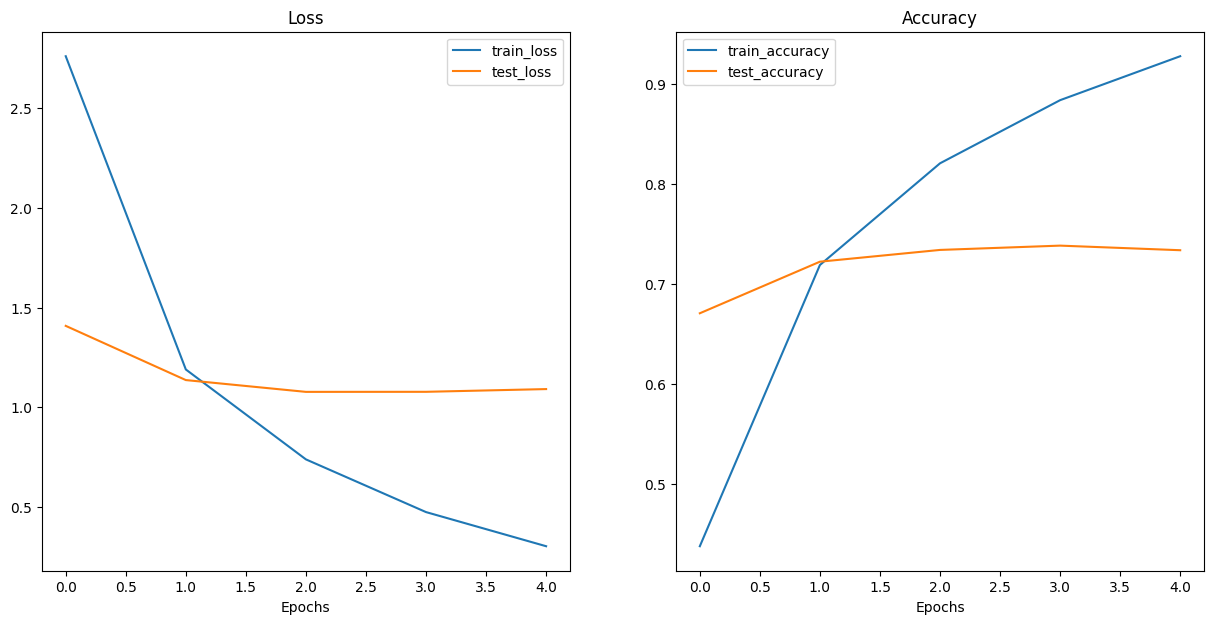

In [65]:
plot_loss_curves(results)

#ONNX

In [66]:
!pip install onnx

In [67]:
!pip install onnxruntime-gpu onnx onnxconverter_common==1.8.1 pillow

In [68]:
x = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
torch.onnx.export(model.cuda(),                                       # model being run
                  x,                                           # model input (or a tuple for multiple inputs)
                  "vgg.onnx",                            # where to save the model (can be a file or file-like object)
                  export_params=True,                          # store the trained parameter weights inside the model file
                  opset_version=10,                            # the ONNX version to export the model to
                  do_constant_folding=True,                    # whether to execute constant folding for optimization
                  input_names = ['input'],                     # the model's input names
                  output_names = ['output'],                   # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},  # variable length axes
                                'output': {0 : 'batch_size'}})